In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
import numpy as np

import matplotlib as mpl

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

In [4]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

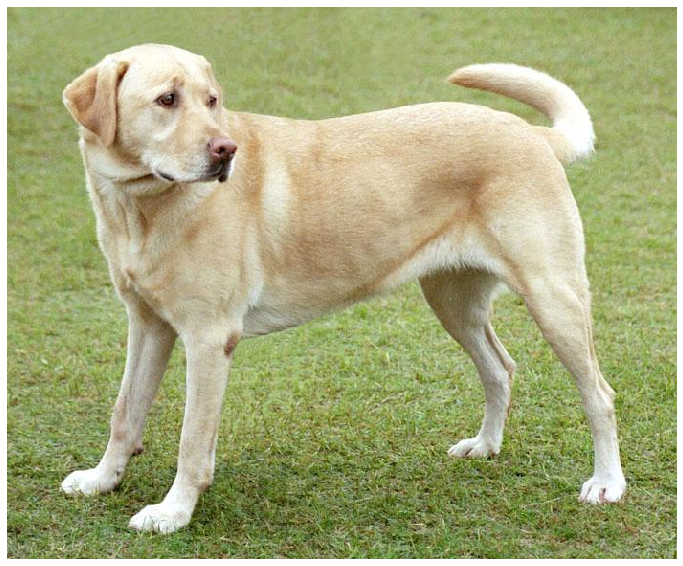

In [5]:
# Download an image and read it into a NumPy array.
def download(url, target_size=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    return img

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)


# Display an image
def show(img):
    plt.figure(figsize=(12,12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

# Downsizing the image makes it easier to work with.
original_img = download(url, target_size=[225, 375])
original_img = np.array(original_img)

show(original_img)

In [6]:
original_img.shape

(577, 700, 3)

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [8]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [9]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [10]:
@tf.function
def deepdream(model, img, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to `img`
      # `GradientTape` only watches `tf.Variable`s by default
        tape.watch(img)
        loss = calc_loss(img, model)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    
    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)

    return loss, img

In [11]:
def run_deep_dream_simple(model, img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    for step in range(steps):
        loss, img = deepdream(model, img, step_size)
    
    if step % 100 == 0:
        clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    clear_output(wait=True)
    show(result)

    return result

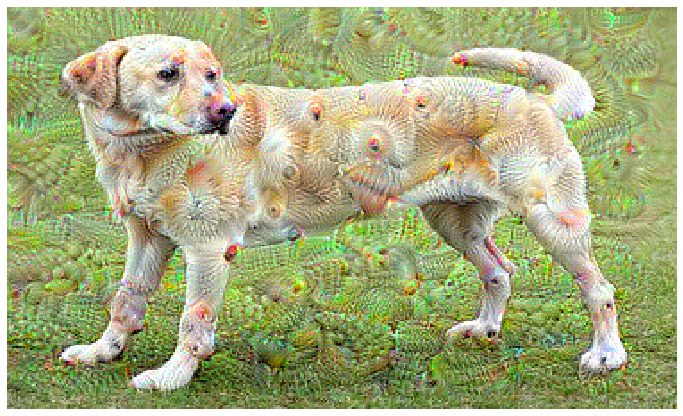

In [12]:
dream_img = run_deep_dream_simple(model=dream_model, img=original_img, 
                                  steps=800, step_size=0.001)

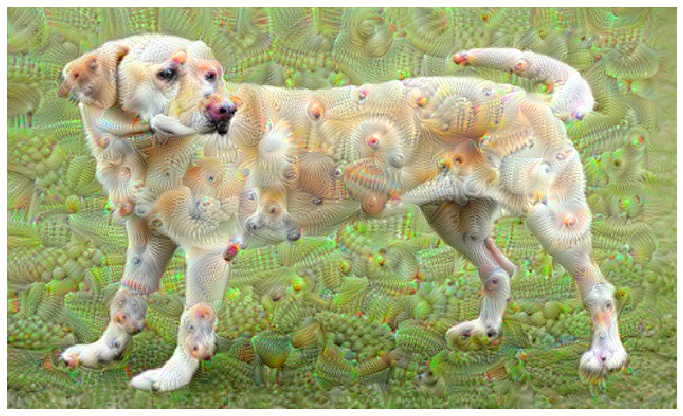

In [13]:
OCTAVE_SCALE = 1.3

img = tf.constant(np.array(original_img))
base_shape = tf.cast(tf.shape(img)[:-1], tf.float32)

for n in range(3):
    new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(model=dream_model, img=img, steps=200, step_size=0.001)

clear_output(wait=True)
show(img)

In [14]:
def random_roll(img, maxroll):
    # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0],shift[1] 
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled

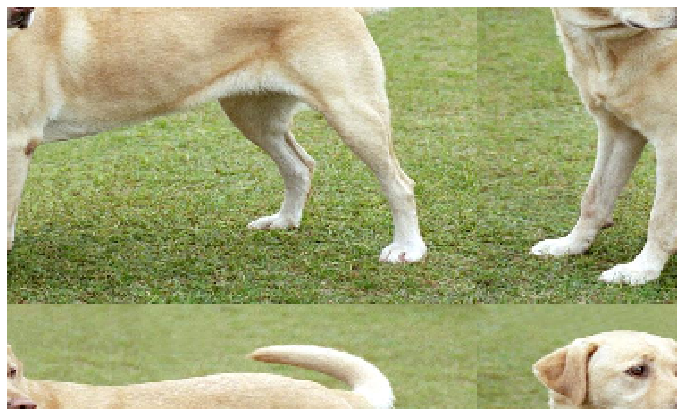

In [15]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [16]:
@tf.function
def get_tiled_gradients(model, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    for x in tf.range(0, img_rolled.shape[0], tile_size):
        for y in tf.range(0, img_rolled.shape[1], tile_size):
            # Calculate the gradients for this tile.
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img_rolled`.
                # `GradientTape` only watches `tf.Variable`s by default.
                tape.watch(img_rolled)

                # Extract a tile out of the image.
                img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                loss = calc_loss(img_tile, model)

            # Update the image gradients for this tile.
            gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [17]:
def run_deep_dream_with_octaves(model, img, steps_per_octave=100, step_size=0.01, 
                                num_octaves=3, octave_scale=1.3):
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    for octave in range(num_octaves):
        # Scale the image based on the octave
        if octave>0:
            new_size = tf.cast(tf.convert_to_tensor(img.shape[:2]), tf.float32)*octave_scale
            img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
        gradients = get_tiled_gradients(model, img)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

        if step % 10 == 0:
            clear_output(wait=True)
            show(deprocess(img))
            print ("Octave {}, Step {}".format(octave, step))
    
    clear_output(wait=True)
    result = deprocess(img)
    show(result)

    return result

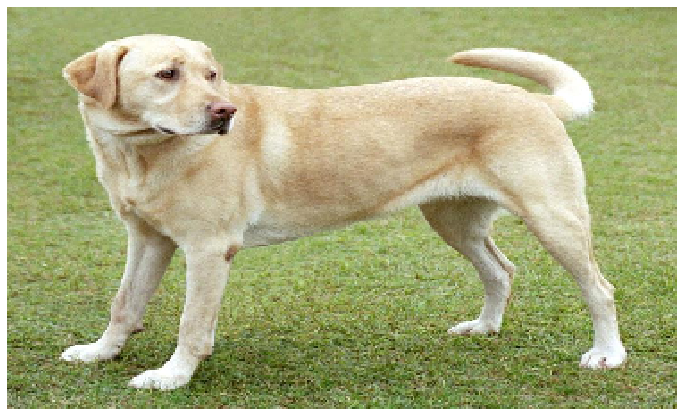

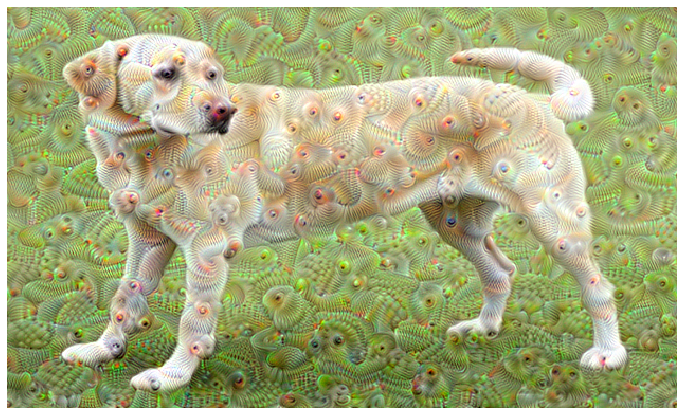

In [18]:
dream_img = run_deep_dream_with_octaves(model=dream_model, img=original_img, step_size=0.01)

clear_output()
show(original_img)
show(dream_img)